In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import xml.etree.ElementTree as ET
import os
import cv2
import tensorflow as tf
from wordcloud import WordCloud
import re
from collections import defaultdict
import itertools
from collections import Counter

In [15]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

ModuleNotFoundError: No module named 'google.colab'

In [9]:
%cd '/content/drive/MyDrive/COMP 576 Final Project'

/content/drive/MyDrive/COMP 576 Final Project


In [16]:
dataset = pd.read_csv("Image-Report.csv")

In [17]:
dataset.drop('Unnamed: 0', inplace=True, axis=1)

In [18]:
dataset

,Image_path,Finding
0,CXR3427_IM-1657-1001,The cardiac silhouette and mediastinum size ar...
1,CXR3427_IM-1657-2001,The cardiac silhouette and mediastinum size ar...
2,CXR3992_IM-2044-1001,NaN
3,CXR3992_IM-2044-2001,NaN
4,CXR3342_IM-1603-1001,The patchy right lower lobe and left lower lob...
...,...,...
7465,CXR769_IM-2314-1001,Clear lungs. No pneumothorax. No pleural effus...
7466,CXR769_IM-2314-2001,Clear lungs. No pneumothorax. No pleural effus...
7467,CXR1071_IM-0051-2001,The heart is normal in size. The pulmonary vas...
7468,CXR1416_IM-0265-1001,The cardiac silhouette is at the upper limits ...


In [19]:
print('Dataset Shape:', dataset.shape)

Dataset Shape: (7470, 2)


In [20]:
for index, row in dataset.iterrows():
  print(row['Image_path'])
  row['Image_path'] = 'Scanned Images/' + row['Image_path'] + '.png'

CXR3427_IM-1657-1001
CXR3427_IM-1657-2001
CXR3992_IM-2044-1001
CXR3992_IM-2044-2001
CXR3342_IM-1603-1001
CXR3342_IM-1603-2001
CXR3019_IM-1393-1001
CXR3439_IM-1664-1001
CXR3439_IM-1664-2001
CXR3925_IM-1999-1002001
CXR3925_IM-1999-1003002
CXR3925_IM-1999-1004003
CXR3210_IM-1517-1001
CXR3170_IM-1494-1001
CXR3170_IM-1494-1002
CXR3407_IM-1647-1001
CXR3407_IM-1647-2001
CXR3620_IM-1791-1001-0001
CXR3620_IM-1791-1001-0002
CXR3054_IM-1422-2002
CXR3054_IM-1422-3003
CXR3673_IM-1828-1001
CXR3673_IM-1828-1002
CXR3344_IM-1603-1001
CXR3344_IM-1603-2001
CXR3433_IM-1662-1001
CXR3433_IM-1662-2001
CXR3706_IM-1851-1001
CXR3706_IM-1851-2001
CXR3509_IM-1711-0001-0001
CXR3509_IM-1711-0001-0002
CXR3509_IM-1711-0001-0003
CXR3352_IM-1608-1001
CXR3352_IM-1608-2001
CXR3313_IM-1586-1001
CXR3313_IM-1586-1002
CXR3553_IM-1741-1001
CXR3553_IM-1741-2001
CXR3817_IM-1925-1001
CXR3817_IM-1925-2001
CXR3646_IM-1808-0001-0001
CXR3646_IM-1808-0001-0002
CXR3284_IM-1565-20001
CXR3849_IM-1947-1001
CXR3849_IM-1947-2001
CXR3090_IM

In [21]:
print('Number of Images:', dataset['Image_path'].nunique())

Number of Images: 7470


In [22]:
dataset = dataset.dropna(axis=0)

In [23]:
dataset.isnull().sum()

Image_path    0
Finding       0
dtype: int64

In [24]:
print(dataset.shape)

(6473, 2)


In [25]:
dataset.head(12)

,Image_path,Finding
0,Scanned Images/CXR3427_IM-1657-1001.png,The cardiac silhouette and mediastinum size ar...
1,Scanned Images/CXR3427_IM-1657-2001.png,The cardiac silhouette and mediastinum size ar...
4,Scanned Images/CXR3342_IM-1603-1001.png,The patchy right lower lobe and left lower lob...
5,Scanned Images/CXR3342_IM-1603-2001.png,The patchy right lower lobe and left lower lob...
6,Scanned Images/CXR3019_IM-1393-1001.png,The heart is normal in size. The mediastinum i...
7,Scanned Images/CXR3439_IM-1664-1001.png,Normal heart size. Clear lungs. No pneumothora...
8,Scanned Images/CXR3439_IM-1664-2001.png,Normal heart size. Clear lungs. No pneumothora...
9,Scanned Images/CXR3925_IM-1999-1002001.png,The lungs are clear. There is no pleural effus...
10,Scanned Images/CXR3925_IM-1999-1003002.png,The lungs are clear. There is no pleural effus...
11,Scanned Images/CXR3925_IM-1999-1004003.png,The lungs are clear. There is no pleural effus...


In [26]:
mapping = defaultdict(int)
find = {}
for imgPath, findings in dataset.values:
  text = imgPath.split('-')
  text.pop(len(text)-1)
  newText = '-'.join(text)
  mapping[newText]+=1
  find[newText] = findings



In [27]:
def splitData(mapping):
    persons = list(mapping.keys())
    persons_train = persons[:3100]
    persons_cv = persons[3100:3200]
    persons_test = persons[3200:]
    return persons_train, persons_cv, persons_test

In [28]:
train, cv, test = splitData(mapping)

In [29]:
def mapImageId(images):

  mapDict = defaultdict(list)
  for id in images:
    for row in dataset['Image_path'].values:
      if id in row:
        mapDict[id].append(row)
  return mapDict

In [30]:
trainMap = mapImageId(train)
cvMap = mapImageId(cv)
testMap = mapImageId(test)

In [31]:
len(testMap), len(testMap)

(150, 150)

In [27]:
count = 0
for name, totalNum in mapping.items():
  if totalNum == 1:
    count+=1

print(count)



390


In [32]:
def finalDataset(data):
  image1 = []
  image2 = []
  patientId = []
  report = []
  for id, l in data.items():
    if len(l) == 1:
      patientId.append(id)
      image1.append(l[0])
      image2.append(l[0])
      report.append(find[id])
    elif len(l) == 2:
      patientId.append(id)
      image1.append(l[0])
      image2.append(l[1])
      report.append(find[id])

  finalDataset = pd.DataFrame()
  finalDataset['Person_id'] = patientId
  finalDataset['Image1'] = image1
  finalDataset['Image2'] = image2
  finalDataset['Report'] = report
  return finalDataset



In [33]:
train = finalDataset(trainMap)
test = finalDataset(testMap)
cv = finalDataset(cvMap)

In [36]:
cv

,Person_id,Image1,Image2,Report
0,Scanned Images/CXR158_IM-0377,Scanned Images/CXR158_IM-0377-1001.png,Scanned Images/CXR158_IM-0377-2001.png,The heart is normal in size and contour. There...
1,Scanned Images/CXR496_IM-2114,Scanned Images/CXR496_IM-2114-1001.png,Scanned Images/CXR496_IM-2114-1002.png,Chest. Lungs are clear and expanded. Heart nor...
2,Scanned Images/CXR494_IM-2114,Scanned Images/CXR494_IM-2114-1001.png,Scanned Images/CXR494_IM-2114-2001.png,Heart size within normal limits. Mediastinal c...
3,Scanned Images/CXR287_IM-1276,Scanned Images/CXR287_IM-1276-1001.png,Scanned Images/CXR287_IM-1276-4004.png,Heart size is normal. The lungs are grossly cl...
4,Scanned Images/CXR152_IM-0335,Scanned Images/CXR152_IM-0335-1001.png,Scanned Images/CXR152_IM-0335-2001.png,Stable cardiomediastinal silhouette with mild ...
...,...,...,...,...
90,Scanned Images/CXR720_IM-2281,Scanned Images/CXR720_IM-2281-1001.png,Scanned Images/CXR720_IM-2281-2001.png,"The cardiac silhouette, upper mediastinum and ..."
91,Scanned Images/CXR760_IM-2310,Scanned Images/CXR760_IM-2310-1001.png,Scanned Images/CXR760_IM-2310-1002.png,There is minimal hyperexpansion and hyperlucen...
92,Scanned Images/CXR854_IM-2376,Scanned Images/CXR854_IM-2376-1001.png,Scanned Images/CXR854_IM-2376-2001.png,The lungs appear clear. The heart and pulmonar...
93,Scanned Images/CXR1306_IM-0200,Scanned Images/CXR1306_IM-0200-2001.png,Scanned Images/CXR1306_IM-0200-3001.png,The XXXX examination consists of frontal and l...


In [40]:
cv['Report'][0]

'The heart is normal in size and contour. There is no mediastinal widening. The lungs are clear bilaterally. No large pleural effusion or pneumothorax. The XXXX are intact.'

## Text Cleaning

In [31]:
import string
import spacy
import nltk
from nltk.corpus import stopwords
import re
import contractions
#nltk.download('stopwords')
def textPreProcessing(text):
    lowerCase = text.lower()

    expanded = []
    for word in lowerCase.split():
        expanded.append(contractions.fix(word)) #expand contractions
    expandedWords = ' '.join(expanded)
    punctuations = string.punctuation
    newString = ""
    for char in punctuations:
      if char != '.':
        newString+=char
    punctuations = newString
    temp = ""
    for char in expandedWords:                      #Lowercase

        if char not in punctuations:            #Remove punctuations
            temp+=char
    noPunct = temp
    res = re.sub(' +', ' ', noPunct)            #Remove extra spaces
    temp = ""
    for char in res:
        if char.isnumeric() == True:
            continue
        else:
            temp+=char

    temp = re.sub(r'x*','',temp)
    mystring = temp.replace("'", "")
    return mystring


In [ ]:
punctuations = string.punctuation
print(punctuations)
newString = ""
for char in punctuations:
  if char != '.':
    newString+=char

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [32]:
for index, row in train.iterrows():
  row['Report'] = textPreProcessing(row['Report'])

for index, row in test.iterrows():
  row['Report'] = textPreProcessing(row['Report'])

for index, row in cv.iterrows():
  row['Report'] = textPreProcessing(row['Report'])




#train['Report'] = textPreProcessing(train['Report'])
##test['Report'] = textPreProcessing(test['Report'])
#cv['Report'] = textPreProcessing(cv['Report'])

In [ ]:
%pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
train['Report'][500]

'the lungs are hyperepanded. the heart is normal in size. the pulmonary vascularity is within normal limits in appearance. no focal airspace opacities pneumothora or pleural effusion. a calcific density in the left midlung zone  represents old granulomatous disease. no acute bony abnormalities.'

In [ ]:
l = [len(e.split()) for e in train['Report'].values]  # Number of words in each report

In [ ]:
max(l)

167

In [ ]:
w = WordCloud(height=1500, width=1500).generate(str(l))

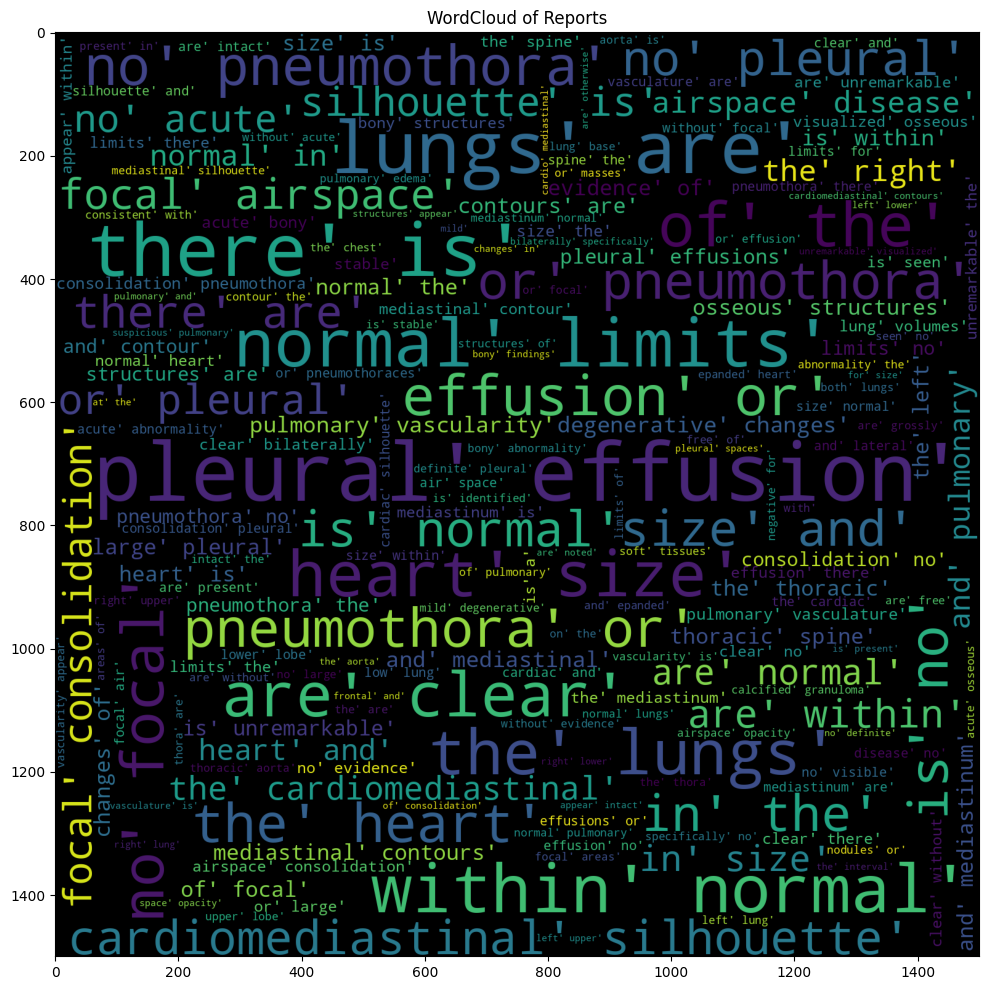

In [ ]:
plt.figure(figsize=(12,12))
plt.title('WordCloud of Reports')
plt.imshow(w)

In [33]:
for index, row in train.iterrows():
  row['Report'] = 'startseq' + ' ' + textPreProcessing(row['Report']) + ' ' + 'endseq'

for index, row in test.iterrows():
  row['Report'] = 'startseq' + ' ' + textPreProcessing(row['Report']) + ' ' + 'endseq'

for index, row in cv.iterrows():
  row['Report'] = 'startseq' + ' ' + textPreProcessing(row['Report']) + ' ' + 'endseq'

In [35]:
# save the cleaned data(STRUCTURED DATA)
train.to_csv('train_Data.csv', index=False)
test.to_csv('test_Data.csv', index=False)
cv.to_csv('cv_Data.csv', index=False)

In [34]:
train['Report'][0]

'startseq the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no of a large pleural effusion. there is no evidence of pneumothora. endseq'

In [1]:
mapping

NameError: name 'mapping' is not defined